In [1]:
!pip install tqdm
!pip install scikit-learn

# Import Libraries/Packages & Datasets

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

cpu


In [3]:
# load data

d1 = pd.read_parquet('./FinalDataset/Device1.parquet')
d2 = pd.read_parquet('./FinalDataset/Device2.parquet')
d3 = pd.read_parquet('./FinalDataset/Device3.parquet')
d4 = pd.read_parquet('./FinalDataset/Device4.parquet')
d5 = pd.read_parquet('./FinalDataset/Device5.parquet')
d6 = pd.read_parquet('./FinalDataset/Device6.parquet')
d7 = pd.read_parquet('./FinalDataset/Device7.parquet')
d8 = pd.read_parquet('./FinalDataset/Device8.parquet')
d9 = pd.read_parquet('./FinalDataset/Device9.parquet')

d1.shape, d2.shape, d3.shape, d4.shape, d5.shape, d6.shape, d7.shape, d8.shape, d9.shape

# load dataset for other types of devices here.....

((1018298, 117),
 (835876, 117),
 (355500, 117),
 (1098677, 117),
 (828260, 117),
 (836891, 117),
 (375222, 117),
 (863056, 117),
 (850826, 117))

# Data Pre-processing

In [4]:
def pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['type'] == 'benign'].drop('type', axis=1)
    benign['type'] = 0

    abnormal = data[data['type'] != 'benign'].drop('type', axis=1)
    abnormal['type'] = 1

    # Split benign data evenly into three parts
    benign_train, benign_tr, benign_test = np.split(benign, [int((1/3)*len(benign)), int((2/3)*len(benign))])
    benign_test_mix = benign_test.copy()  # With label 116

    train_label = benign_train['type']
    benign_train = benign_train.drop('type', axis=1)
    benign_tr = benign_tr.drop('type', axis=1)

    # Create mixed data
    abnormal_sample = abnormal.sample(frac=1)  # Use all abnormal data (frac = 0.1 for selecting 10%)
    mix_temp = pd.concat([benign_test_mix, abnormal_sample]).sample(frac=1, random_state=1)

    mix = mix_temp.copy()  # Mix with label # 116
    mix_data = mix_temp.drop('type', axis=1)  # Only data (115)
    mix_label = mix['type']

    # Standardize data using StandardScaler
    scaler = StandardScaler()
    benign_train = scaler.fit_transform(benign_train)  # 115 all benign
    benign_tr = scaler.transform(benign_tr)  # 115 all benign
    mix_data = scaler.transform(mix_data)  # ([xxx, 115])

    # Convert data to tensors
    benign_tr = torch.from_numpy(benign_tr).float().to(device)  # 115 all benign --> for calculating threshold
    mix_data = torch.from_numpy(mix_data).float().to(device)  # 115 benign + abnormal --> for evaluation
    mix_label = torch.tensor(mix_label.values)

    return benign_train, benign_tr, mix_data, mix_label

In [6]:
# for Federated Model training
benign_train_1, benign_tr_1, mix_data_1, mix_label_1 = pre_processing(d1)
benign_train_2, benign_tr_2, mix_data_2, mix_label_2 = pre_processing(d2)
benign_train_3, benign_tr_3, mix_data_3, mix_label_3 = pre_processing(d3)
benign_train_4, benign_tr_4, mix_data_4, mix_label_4 = pre_processing(d4)
benign_train_5, benign_tr_5, mix_data_5, mix_label_5 = pre_processing(d5)
benign_train_6, benign_tr_6, mix_data_6, mix_label_6 = pre_processing(d6)
benign_train_7, benign_tr_7, mix_data_7, mix_label_7 = pre_processing(d7)
benign_train_8, benign_tr_8, mix_data_8, mix_label_8 = pre_processing(d8)
benign_train_9, benign_tr_9, mix_data_9, mix_label_9 = pre_processing(d9)

# Prepare for training

## Hyperparameters

In [7]:
num_clients = 9      # Number of clients
num_selected = 4    
batch_size = 1024
baseline_num = 1000  # choose some data from the train set to retrain the data from trained model 
num_rounds = 4     # Total number of communication rounds for the global model to train.
epochs = 10          # for train client model
retrain_epochs = 10  # Total number of retraining rounds on the global server after receiving the model weights 
                      # from all the clients that participated in the communication round.

## Retraining Mechanism

In [8]:
def baseline_data(size=baseline_num, batch_size=batch_size):
    loaders = {
        'D1': torch.utils.data.DataLoader(benign_train_1, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_1, replacement=True, num_samples=size)),
        'D2': torch.utils.data.DataLoader(benign_train_2, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_2, replacement=True, num_samples=size)),
        'D3': torch.utils.data.DataLoader(benign_train_3, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_3, replacement=True, num_samples=size)),
        'D4': torch.utils.data.DataLoader(benign_train_4, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_4, replacement=True, num_samples=size)),
        'D5': torch.utils.data.DataLoader(benign_train_5, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_5, replacement=True, num_samples=size)),
        'D6': torch.utils.data.DataLoader(benign_train_6, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_6, replacement=True, num_samples=size)),
        'D7': torch.utils.data.DataLoader(benign_train_7, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_7, replacement=True, num_samples=size)),
        'D8': torch.utils.data.DataLoader(benign_train_8, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_8, replacement=True, num_samples=size)),
        'D9': torch.utils.data.DataLoader(benign_train_9, batch_size=batch_size, sampler=torch.utils.data.RandomSampler(benign_train_9, replacement=True, num_samples=size))
    }

    return loaders


## FedAvgM

In [9]:


def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    global_dict = global_model.state_dict()
    temp_dict = copy.deepcopy(global_dict)
    v = {x: 1 for x in global_dict}

    for i, k in enumerate(global_dict.keys()):
        avg_weight = sum(client_models[j].state_dict()[k].float() * (n * client_lens[j] / total) for j in range(n)) / n
        temp_dict[k] = avg_weight
        temp_v = 0.9 * v[k] + temp_dict[k]
        global_dict[k] -= temp_v
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

## Utilities

In [10]:
def train_data_loaders(batch_size=batch_size):
    client_loaders = {}
    for i in range(1, 10):
        data = torch.utils.data.DataLoader(globals()[f'benign_train_{i}'], batch_size=batch_size, shuffle=True)
        client_loaders[f'D{i}'] = data

    return client_loaders


In [11]:
import torch.nn.functional as F

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for _ in range(epoch):
        running_loss = 0.0
        for data in train_data:
            optimizer.zero_grad()
            output = client_model(data.float().to(device))
            loss = F.mse_loss(data.float().to(device), output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_data)
    return epoch_loss

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())


## Deep Auto-encoder Model

In [12]:
input_dim = 115

class AEModel(nn.Module):
    def __init__(self):
        super(AEModel, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(0.75 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75 * input_dim), int(0.5 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5 * input_dim), int(0.33 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33 * input_dim), int(0.25 * input_dim)),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(int(0.25 * input_dim), int(0.33 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33 * input_dim), int(0.5 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5 * input_dim), int(0.75 * input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75 * input_dim), int(input_dim)),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Initialisation

In [13]:
# Initialize global model and client models
global_model = AEModel().to(device)
client_models = [AEModel().to(device) for _ in range(num_selected)]
for client_model in client_models:
    client_model.load_state_dict(global_model.state_dict())

# Initialize optimizers for client models
client_optimizers = [torch.optim.SGD(client_model.parameters(), lr=0.012, weight_decay=1e-05, momentum=0.9) for client_model in client_models]


In [14]:
baseline_data = baseline_data() # size = 1000
train_loader = train_data_loaders() #batch_size=128
devices = ['D1','D2','D3','D4','D5','D6','D7','D8','D9']

# Training Federated Model

In [15]:
# Train Client Model and Global Model
client_losses = []
global_losses = []

start_time = time.time()

for round_idx in range(num_rounds):  # Total number of rounds
    print('\nRound:', round_idx + 1)
    client_indices = np.random.permutation(num_clients)[:num_selected]  # Randomly select clients for training
    print('Client Indices:', client_indices)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_indices]

    # Client Update
    client_loss = 0
    for i in tqdm(range(num_selected)):
        client_syn(client_models[i], global_model)
        client_loss += client_update(client_models[i], client_optimizers[i], train_loader[devices[client_indices[i]]], epochs)
    client_losses.append(client_loss)

    # Retraining on the Global Server
    global_loss_retrain = 0
    for i in tqdm(range(num_selected)):
        global_loss_retrain += client_update(client_models[i], client_optimizers[i], baseline_data[devices[client_indices[i]]], retrain_epochs)
    global_losses.append(global_loss_retrain / num_selected)

    # Aggregate Models
    server_aggregate_M(global_model, client_models, client_lens)  # FedAvgM

    print('\nClient Loss:', client_loss)
    print('Global Loss:', global_loss_retrain / num_selected)

# Save the Global Model
torch.save(global_model, 'global.pt')

time_required = time.time() - start_time
print('\nTime Required: {} mins'.format(time_required / 60))



Round: 1
Client Indices: [5 4 6 2]


100%|██████████| 4/4 [00:00<00:00, 13.26it/s]



Client Loss: 2.416405899527351
Global Loss: 0.6395665183663368

Round: 2
Client Indices: [8 1 6 7]


100%|██████████| 4/4 [00:00<00:00, 18.85it/s]



Client Loss: 5.713152021883415
Global Loss: 1.4339208006858826

Round: 3
Client Indices: [0 1 2 3]


100%|██████████| 4/4 [00:00<00:00, 14.47it/s]



Client Loss: 5.9281058871201076
Global Loss: 1.421762615442276

Round: 4
Client Indices: [3 4 8 1]


100%|██████████| 4/4 [00:00<00:00, 12.61it/s]



Client Loss: 5.42287356401312
Global Loss: 1.3787338733673096

Round: 5
Client Indices: [7 0 8 6]


100%|██████████| 4/4 [00:00<00:00, 15.45it/s]



Client Loss: 6.097896438999838
Global Loss: 1.436872959136963

Round: 6
Client Indices: [4 5 0 6]


100%|██████████| 4/4 [00:00<00:00, 15.58it/s]



Client Loss: 5.105768535818372
Global Loss: 1.1836527287960052

Round: 7
Client Indices: [4 1 5 2]


100%|██████████| 4/4 [00:00<00:00, 13.63it/s]



Client Loss: 4.733361560787076
Global Loss: 1.107986494898796

Round: 8
Client Indices: [0 6 8 1]


100%|██████████| 4/4 [00:00<00:00, 16.91it/s]



Client Loss: 5.872340213751593
Global Loss: 1.3257691860198975

Round: 9
Client Indices: [6 1 5 4]


100%|██████████| 4/4 [00:00<00:00, 15.04it/s]



Client Loss: 4.7166123364212735
Global Loss: 1.2032108157873154

Round: 10
Client Indices: [3 4 6 2]


100%|██████████| 4/4 [00:00<00:00, 15.59it/s]



Client Loss: 5.32047593903558
Global Loss: 1.3132199048995972

Round: 11
Client Indices: [8 0 4 1]


100%|██████████| 4/4 [00:00<00:00, 15.20it/s]



Client Loss: 5.528044187321383
Global Loss: 1.3319042026996613

Round: 12
Client Indices: [4 2 3 0]


100%|██████████| 4/4 [00:00<00:00, 14.68it/s]



Client Loss: 5.633995929201468
Global Loss: 1.3535596132278442

Round: 13
Client Indices: [3 7 6 1]


100%|██████████| 4/4 [00:00<00:00, 14.18it/s]



Client Loss: 5.743721608593909
Global Loss: 1.4765589535236359

Round: 14
Client Indices: [8 6 2 7]


100%|██████████| 4/4 [00:00<00:00, 15.06it/s]



Client Loss: 5.786706181355038
Global Loss: 1.4519389271736145

Round: 15
Client Indices: [5 3 1 4]


100%|██████████| 4/4 [00:00<00:00, 14.40it/s]



Client Loss: 4.888042077578294
Global Loss: 1.1589103043079376

Round: 16
Client Indices: [6 5 8 1]


100%|██████████| 4/4 [00:00<00:00, 15.50it/s]



Client Loss: 5.261990331213134
Global Loss: 1.3196372389793396

Round: 17
Client Indices: [2 5 3 7]


100%|██████████| 4/4 [00:00<00:00, 15.79it/s]



Client Loss: 5.558278603268014
Global Loss: 1.3830103278160095

Round: 18
Client Indices: [5 7 6 2]


100%|██████████| 4/4 [00:00<00:00, 14.07it/s]



Client Loss: 5.350203539216353
Global Loss: 1.4374269396066666

Round: 19
Client Indices: [1 0 8 7]


100%|██████████| 4/4 [00:00<00:00, 19.88it/s]



Client Loss: 6.040144794102477
Global Loss: 1.4000013172626495

Round: 20
Client Indices: [4 8 5 1]


100%|██████████| 4/4 [00:00<00:00, 14.92it/s]



Client Loss: 4.875868225200867
Global Loss: 1.1690813601016998

Round: 21
Client Indices: [1 8 7 2]


100%|██████████| 4/4 [00:00<00:00, 13.76it/s]



Client Loss: 5.7399002461479265
Global Loss: 1.4663998782634735

Round: 22
Client Indices: [4 5 6 2]


100%|██████████| 4/4 [00:00<00:00, 16.09it/s]



Client Loss: 4.8014317106979725
Global Loss: 1.1579910814762115

Round: 23
Client Indices: [0 4 1 8]


100%|██████████| 4/4 [00:00<00:00, 12.59it/s]



Client Loss: 5.47490191139093
Global Loss: 1.308418095111847

Round: 24
Client Indices: [7 2 3 0]


100%|██████████| 4/4 [00:00<00:00, 16.24it/s]



Client Loss: 6.148924321690677
Global Loss: 1.5516526699066162

Round: 25
Client Indices: [7 3 1 0]


100%|██████████| 4/4 [00:00<00:00, 14.72it/s]



Client Loss: 6.036025037877941
Global Loss: 1.5480349957942963

Round: 26
Client Indices: [1 3 8 5]


100%|██████████| 4/4 [00:00<00:00, 14.39it/s]



Client Loss: 5.438938319223961
Global Loss: 1.3612014949321747

Round: 27
Client Indices: [8 7 5 6]


100%|██████████| 4/4 [00:00<00:00, 15.83it/s]



Client Loss: 5.474835886295315
Global Loss: 1.3265868723392487

Round: 28
Client Indices: [0 2 3 5]


100%|██████████| 4/4 [00:00<00:00, 12.73it/s]



Client Loss: 5.685613883027124
Global Loss: 1.4346308708190918

Round: 29
Client Indices: [8 6 4 7]


100%|██████████| 4/4 [00:00<00:00, 14.85it/s]



Client Loss: 5.418979920092083
Global Loss: 1.3422836065292358

Round: 30
Client Indices: [6 4 0 1]


100%|██████████| 4/4 [00:00<00:00, 15.82it/s]



Client Loss: 5.369336784453619
Global Loss: 1.3126387745141983

Round: 31
Client Indices: [8 2 4 0]


100%|██████████| 4/4 [00:00<00:00, 15.13it/s]



Client Loss: 5.56731878682422
Global Loss: 1.4430720955133438

Round: 32
Client Indices: [0 8 2 4]


100%|██████████| 4/4 [00:00<00:00, 12.68it/s]



Client Loss: 5.628461076136525
Global Loss: 1.4407647401094437

Round: 33
Client Indices: [2 5 0 7]


100%|██████████| 4/4 [00:00<00:00, 13.46it/s]



Client Loss: 5.608526504676838
Global Loss: 1.5882576406002045

Round: 34
Client Indices: [2 1 5 7]


100%|██████████| 4/4 [00:00<00:00, 13.68it/s]



Client Loss: 5.245369271763833
Global Loss: 1.3290561437606812

Round: 35
Client Indices: [4 1 5 6]


100%|██████████| 4/4 [00:00<00:00, 15.21it/s]



Client Loss: 4.705512956477681
Global Loss: 1.1961226165294647

Round: 36
Client Indices: [7 5 3 2]


100%|██████████| 4/4 [00:00<00:00,  9.68it/s]



Client Loss: 5.493186330745102
Global Loss: 1.444487452507019

Round: 37
Client Indices: [8 6 0 4]


100%|██████████| 4/4 [00:00<00:00, 14.10it/s]



Client Loss: 5.626669843156799
Global Loss: 1.3060577660799026

Round: 38
Client Indices: [7 4 1 3]


100%|██████████| 4/4 [00:00<00:00, 16.24it/s]



Client Loss: 5.3895150325201415
Global Loss: 1.2236799746751785

Round: 39
Client Indices: [8 2 6 3]


100%|██████████| 4/4 [00:00<00:00, 15.74it/s]



Client Loss: 5.849214233966395
Global Loss: 1.4833260476589203

Round: 40
Client Indices: [3 5 1 2]


100%|██████████| 4/4 [00:00<00:00, 15.92it/s]



Client Loss: 5.275179103037694
Global Loss: 1.2968455255031586

Round: 41
Client Indices: [0 3 5 6]


100%|██████████| 4/4 [00:00<00:00, 13.25it/s]



Client Loss: 5.6404244908689165
Global Loss: 1.4050509333610535

Round: 42
Client Indices: [3 2 0 6]


100%|██████████| 4/4 [00:00<00:00, 15.92it/s]



Client Loss: 6.030954632154213
Global Loss: 1.5001272559165955

Round: 43
Client Indices: [0 1 8 3]


100%|██████████| 4/4 [00:00<00:00, 18.10it/s]



Client Loss: 6.134373967545995
Global Loss: 1.6046023964881897

Round: 44
Client Indices: [1 6 0 7]


100%|██████████| 4/4 [00:00<00:00, 16.27it/s]



Client Loss: 5.921106467176886
Global Loss: 1.3962635695934296

Round: 45
Client Indices: [3 0 2 1]


100%|██████████| 4/4 [00:00<00:00, 14.08it/s]



Client Loss: 5.957724918804296
Global Loss: 1.426261305809021

Round: 46
Client Indices: [3 0 5 1]


100%|██████████| 4/4 [00:00<00:00, 14.79it/s]



Client Loss: 5.576122232866943
Global Loss: 1.493093878030777

Round: 47
Client Indices: [6 8 3 2]


100%|██████████| 4/4 [00:00<00:00, 14.91it/s]



Client Loss: 5.831106273502538
Global Loss: 1.4386366307735443

Round: 48
Client Indices: [7 3 4 5]


100%|██████████| 4/4 [00:00<00:00, 15.84it/s]



Client Loss: 5.10141041387745
Global Loss: 1.271352231502533

Round: 49
Client Indices: [5 8 7 3]


100%|██████████| 4/4 [00:00<00:00, 13.00it/s]



Client Loss: 5.613721602508063
Global Loss: 1.429059237241745

Round: 50
Client Indices: [2 8 1 5]


100%|██████████| 4/4 [00:00<00:00, 18.02it/s]



Client Loss: 5.237321388324499
Global Loss: 1.2956933081150055

Round: 51
Client Indices: [4 7 6 5]


100%|██████████| 4/4 [00:00<00:00, 18.02it/s]



Client Loss: 4.91875271761929
Global Loss: 1.166926547884941

Round: 52
Client Indices: [8 6 0 4]


100%|██████████| 4/4 [00:00<00:00, 15.74it/s]



Client Loss: 5.626020005437172
Global Loss: 1.3136471807956696

Round: 53
Client Indices: [8 5 1 4]


100%|██████████| 4/4 [00:00<00:00, 13.91it/s]



Client Loss: 4.866604995779145
Global Loss: 1.2354479432106018

Round: 54
Client Indices: [6 5 7 0]


100%|██████████| 4/4 [00:00<00:00, 17.25it/s]



Client Loss: 5.686787209873637
Global Loss: 1.3491762280464172

Round: 55
Client Indices: [4 2 5 0]


100%|██████████| 4/4 [00:00<00:00, 17.25it/s]



Client Loss: 5.171979528307454
Global Loss: 1.2804958820343018

Round: 56
Client Indices: [3 0 6 7]


100%|██████████| 4/4 [00:00<00:00, 17.32it/s]



Client Loss: 6.114432607805753
Global Loss: 1.5889396369457245

Round: 57
Client Indices: [2 5 8 0]


100%|██████████| 4/4 [00:00<00:00, 18.11it/s]



Client Loss: 5.608871011629537
Global Loss: 1.5698068737983704

Round: 58
Client Indices: [3 1 0 7]


100%|██████████| 4/4 [00:00<00:00, 17.42it/s]



Client Loss: 6.044653259465588
Global Loss: 1.4915182292461395

Round: 59
Client Indices: [7 5 1 4]


100%|██████████| 4/4 [00:00<00:00, 14.67it/s]



Client Loss: 4.851356041857175
Global Loss: 1.1792361289262772

Round: 60
Client Indices: [5 8 2 7]


100%|██████████| 4/4 [00:00<00:00, 16.33it/s]



Client Loss: 5.451628075563388
Global Loss: 1.317244052886963

Round: 61
Client Indices: [5 8 0 3]


100%|██████████| 4/4 [00:00<00:00, 17.79it/s]



Client Loss: 5.790259407643181
Global Loss: 1.4382494240999222

Round: 62
Client Indices: [2 1 0 4]


100%|██████████| 4/4 [00:00<00:00, 18.45it/s]



Client Loss: 5.382365510769893
Global Loss: 1.3943379819393158

Round: 63
Client Indices: [1 8 2 7]


100%|██████████| 4/4 [00:00<00:00, 18.15it/s]



Client Loss: 5.716358651564672
Global Loss: 1.4735904932022095

Round: 64
Client Indices: [1 6 2 0]


100%|██████████| 4/4 [00:00<00:00, 18.32it/s]



Client Loss: 5.739233694788558
Global Loss: 1.4664711952209473

Round: 65
Client Indices: [5 0 4 7]


100%|██████████| 4/4 [00:00<00:00, 15.39it/s]



Client Loss: 5.239469489861998
Global Loss: 1.2950105369091034

Round: 66
Client Indices: [3 5 7 8]


100%|██████████| 4/4 [00:00<00:00, 16.14it/s]



Client Loss: 5.621857866374597
Global Loss: 1.4234966486692429

Round: 67
Client Indices: [3 2 6 0]


100%|██████████| 4/4 [00:00<00:00, 16.07it/s]



Client Loss: 6.024945081126618
Global Loss: 1.4971169531345367

Round: 68
Client Indices: [4 3 1 8]


100%|██████████| 4/4 [00:00<00:00, 15.92it/s]



Client Loss: 5.362715254197958
Global Loss: 1.3140387386083603

Round: 69
Client Indices: [1 5 2 6]


100%|██████████| 4/4 [00:00<00:00, 19.29it/s]



Client Loss: 5.11428617604979
Global Loss: 1.3103806376457214

Round: 70
Client Indices: [5 3 8 0]


100%|██████████| 4/4 [00:00<00:00, 18.20it/s]



Client Loss: 5.777137101378797
Global Loss: 1.4593394696712494

Round: 71
Client Indices: [5 3 8 0]


100%|██████████| 4/4 [00:00<00:00, 12.69it/s]



Client Loss: 5.8079442062442235
Global Loss: 1.494787484407425

Round: 72
Client Indices: [6 4 7 8]


100%|██████████| 4/4 [00:00<00:00, 17.95it/s]



Client Loss: 5.378677865996414
Global Loss: 1.4115338921546936

Round: 73
Client Indices: [4 7 2 6]


100%|██████████| 4/4 [00:00<00:00, 16.73it/s]



Client Loss: 5.2829725243900905
Global Loss: 1.2978618144989014

Round: 74
Client Indices: [3 7 4 5]


100%|██████████| 4/4 [00:00<00:00, 18.15it/s]



Client Loss: 5.138635146934197
Global Loss: 1.2351363003253937

Round: 75
Client Indices: [3 4 2 5]


100%|██████████| 4/4 [00:00<00:00, 16.05it/s]



Client Loss: 4.9872858918476854
Global Loss: 1.2589202374219894

Round: 76
Client Indices: [5 6 1 0]


100%|██████████| 4/4 [00:00<00:00, 17.81it/s]



Client Loss: 5.409514222723065
Global Loss: 1.4770377278327942

Round: 77
Client Indices: [0 2 4 6]


100%|██████████| 4/4 [00:00<00:00, 19.36it/s]



Client Loss: 5.45989541310325
Global Loss: 1.2899597883224487

Round: 78
Client Indices: [4 8 3 5]


100%|██████████| 4/4 [00:00<00:00, 16.25it/s]



Client Loss: 5.122258240277242
Global Loss: 1.2499211877584457

Round: 79
Client Indices: [2 6 8 5]


100%|██████████| 4/4 [00:00<00:00, 18.21it/s]



Client Loss: 5.342238379143349
Global Loss: 1.2865040600299835

Round: 80
Client Indices: [6 0 3 7]


100%|██████████| 4/4 [00:00<00:00, 18.06it/s]



Client Loss: 6.122960968022414
Global Loss: 1.5706501603126526

Round: 81
Client Indices: [4 0 3 2]


100%|██████████| 4/4 [00:00<00:00, 18.17it/s]



Client Loss: 5.627908546733947
Global Loss: 1.2861507385969162

Round: 82
Client Indices: [5 3 6 7]


100%|██████████| 4/4 [00:00<00:00, 17.53it/s]



Client Loss: 5.4754078451183865
Global Loss: 1.5344031751155853

Round: 83
Client Indices: [4 6 1 0]


100%|██████████| 4/4 [00:00<00:00, 17.98it/s]



Client Loss: 5.355795737742042
Global Loss: 1.4214760661125183

Round: 84
Client Indices: [1 2 4 0]


100%|██████████| 4/4 [00:00<00:00, 17.86it/s]



Client Loss: 5.403169535003174
Global Loss: 1.272927388548851

Round: 85
Client Indices: [1 6 3 5]


100%|██████████| 4/4 [00:00<00:00, 17.74it/s]



Client Loss: 5.312047246573149
Global Loss: 1.2879189252853394

Round: 86
Client Indices: [7 6 5 3]


100%|██████████| 4/4 [00:00<00:00, 16.45it/s]



Client Loss: 5.50578324463269
Global Loss: 1.325781375169754

Round: 87
Client Indices: [4 7 6 8]


100%|██████████| 4/4 [00:00<00:00, 16.15it/s]



Client Loss: 5.394596346849654
Global Loss: 1.3618569672107697

Round: 88
Client Indices: [4 6 1 0]


100%|██████████| 4/4 [00:00<00:00, 15.62it/s]



Client Loss: 5.351233172316511
Global Loss: 1.394532486796379

Round: 89
Client Indices: [3 8 5 1]


100%|██████████| 4/4 [00:00<00:00, 18.32it/s]



Client Loss: 5.454334199620746
Global Loss: 1.326745629310608

Round: 90
Client Indices: [4 6 0 1]


100%|██████████| 4/4 [00:00<00:00, 19.50it/s]



Client Loss: 5.362648349816725
Global Loss: 1.3267545104026794

Round: 91
Client Indices: [2 6 4 8]


100%|██████████| 4/4 [00:00<00:00, 17.71it/s]



Client Loss: 5.273179066756551
Global Loss: 1.248400017619133

Round: 92
Client Indices: [5 8 0 2]


100%|██████████| 4/4 [00:00<00:00, 16.20it/s]



Client Loss: 5.630681848989986
Global Loss: 1.442481905221939

Round: 93
Client Indices: [6 5 7 2]


100%|██████████| 4/4 [00:00<00:00, 16.61it/s]



Client Loss: 5.3219427137813025
Global Loss: 1.3038058131933212

Round: 94
Client Indices: [6 0 1 4]


100%|██████████| 4/4 [00:00<00:00, 18.15it/s]



Client Loss: 5.343428074578945
Global Loss: 1.3013968765735626

Round: 95
Client Indices: [2 1 0 8]


100%|██████████| 4/4 [00:00<00:00, 17.91it/s]



Client Loss: 5.984935545181566
Global Loss: 1.5778031647205353

Round: 96
Client Indices: [2 5 1 8]


100%|██████████| 4/4 [00:00<00:00, 17.79it/s]



Client Loss: 5.2196041580720065
Global Loss: 1.2914176881313324

Round: 97
Client Indices: [3 8 2 5]


100%|██████████| 4/4 [00:00<00:00, 17.92it/s]



Client Loss: 5.511854000846858
Global Loss: 1.3152495324611664

Round: 98
Client Indices: [5 7 4 3]


100%|██████████| 4/4 [00:00<00:00, 15.81it/s]



Client Loss: 5.114593681912846
Global Loss: 1.2752579897642136

Round: 99
Client Indices: [2 7 3 4]


100%|██████████| 4/4 [00:00<00:00, 16.81it/s]



Client Loss: 5.450039434092498
Global Loss: 1.422967553138733

Round: 100
Client Indices: [4 7 5 2]


100%|██████████| 4/4 [00:00<00:00, 16.59it/s]


Client Loss: 4.9247779845174176
Global Loss: 1.1806320697069168

Time Required: 42.98698606093725 mins


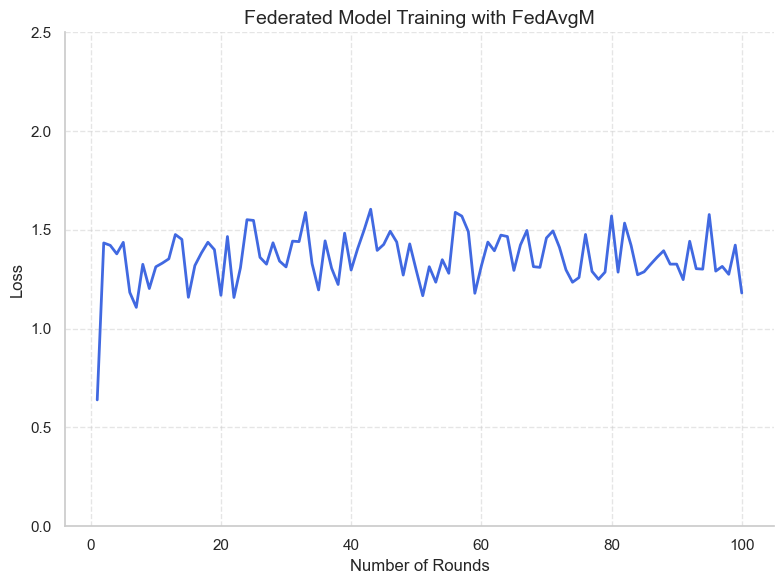

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot train_loss_global
rounds = range(1, num_rounds + 1)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(rounds, global_losses, color='royalblue', linewidth=2)
plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim((0, 2.5))
plt.title('Federated Model Training with FedAvgM', fontsize=14)

# Add grid and remove top/right spines
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


# Evaluation

In [17]:
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score


def get_threshold(model, tr_data):
    model.eval()
    mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    tr = mse.mean() + mse.std()
    return tr

def calculate_performance(y_actual, y_pred):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
            TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
            FP += 1
        if y_actual[i] == y_pred[i] == 0:
            TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
            FN += 1
    return TP, FP, TN, FN

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    mse = np.mean(np.power(mix_data.cpu().detach().numpy() - model(mix_data).cpu().detach().numpy(), 2), axis=1)

    predictions = []
    for i in mse:
        if i > tr:
            predictions.append(1)
        else:
            predictions.append(0)

    mix_label_list = mix_label.tolist()
    TP, FP, TN, FN = calculate_performance(mix_label_list, predictions)

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * ((precision * recall) / (precision + recall))
    TPR = round((TP / (TP + FN)), 6)
    FPR = round((FP / (FP + TN)), 6)

    specificity = TN / (FP + TN)  # Specificity or True Negative Rate
    NPV = TN / (TN + FN)  # Negative Predictive Value
    FNR = FN / (TP + FN)  # False Negative Rate
    auc = roc_auc_score(mix_label_list, predictions)

    performance = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1_score': F1_score,
        'TPR': TPR,
        'FPR': FPR,
        'specificity': specificity,
        'NPV': NPV,
        'AUC': auc
    }

    return performance




In [18]:
# load model
global_model = torch.load('global.pt')

# Test on client devices

In [19]:
# Calculate TR
tr_1 = get_threshold(global_model, benign_tr_1)
tr_2 = get_threshold(global_model, benign_tr_2)
tr_3 = get_threshold(global_model, benign_tr_3)
tr_4 = get_threshold(global_model, benign_tr_4)
tr_5 = get_threshold(global_model, benign_tr_5)
tr_6 = get_threshold(global_model, benign_tr_6)
tr_7 = get_threshold(global_model, benign_tr_7)
tr_8 = get_threshold(global_model, benign_tr_8)
tr_9 = get_threshold(global_model, benign_tr_9)

In [20]:
# use global model & device's TR
print("D1: ")
get_mix_result(global_model, tr_1, mix_data_1, mix_label_1)

D1: 


{'accuracy': 0.999866026027489,
 'precision': 0.9998802704236982,
 'recall': 0.9999834838709677,
 'F1_score': 0.9999318744838975,
 'TPR': 0.999983,
 'FPR': 0.007023,
 'specificity': 0.9929765076289658,
 'NPV': 0.9990253411306043,
 'AUC': 0.9964799957499667}

In [21]:

print('\nD2: ')
get_mix_result(global_model, tr_2, mix_data_2, mix_label_2)



D2: 


{'accuracy': 0.9997823810894003,
 'precision': 0.9997812728220545,
 'recall': 1.0,
 'F1_score': 0.9998906244493245,
 'TPR': 1.0,
 'FPR': 0.041181,
 'specificity': 0.9588194921070693,
 'NPV': 1.0,
 'AUC': 0.9794097460535346}

In [22]:
print("\nD3: ")
get_mix_result(global_model, tr_3, mix_data_3, mix_label_3)


D3: 


{'accuracy': 0.3763060279145443,
 'precision': 0.999441733148445,
 'recall': 0.35080910240202273,
 'F1_score': 0.5193305541129186,
 'TPR': 0.350809,
 'FPR': 0.004757,
 'specificity': 0.9952432100659813,
 'NPV': 0.05940213210242884,
 'AUC': 0.6730261562340021}

In [23]:

print('\nD4: ')
get_mix_result(global_model, tr_4, mix_data_4, mix_label_4)


D4: 


{'accuracy': 0.9985109756979419,
 'precision': 0.9985583594065156,
 'recall': 0.9998603044928891,
 'F1_score': 0.9992089078491275,
 'TPR': 0.99986,
 'FPR': 0.02282,
 'specificity': 0.9771801280514945,
 'NPV': 0.997745149449397,
 'AUC': 0.9885202162721918}

In [24]:
print("D5: ")
get_mix_result(global_model, tr_5, mix_data_5, mix_label_5)

D5: 


{'accuracy': 0.9992361697152095,
 'precision': 0.9992708280341185,
 'recall': 0.9999451772992249,
 'F1_score': 0.9996078889353565,
 'TPR': 0.999945,
 'FPR': 0.026981,
 'specificity': 0.9730186311420022,
 'NPV': 0.9979208950051978,
 'AUC': 0.9864819042206137}

In [25]:
print('\nD6: ')
get_mix_result(global_model, tr_6, mix_data_6, mix_label_6)



D6: 


{'accuracy': 0.9987020480670111,
 'precision': 0.9987540887803057,
 'recall': 0.999891654263337,
 'F1_score': 0.9993225477888055,
 'TPR': 0.999892,
 'FPR': 0.028047,
 'specificity': 0.971953224922346,
 'NPV': 0.9974997656030253,
 'AUC': 0.9859224395928415}

In [26]:
print('\nD7: ')
get_mix_result(global_model, tr_7, mix_data_7, mix_label_7)


D7: 


{'accuracy': 0.9988339168644407,
 'precision': 0.9991677314959485,
 'recall': 0.9996038034865293,
 'F1_score': 0.9993857199223253,
 'TPR': 0.999604,
 'FPR': 0.015474,
 'specificity': 0.9845260009203866,
 'NPV': 0.9925766977904077,
 'AUC': 0.9920649022034579}

In [27]:
print("\nD8: ")
get_mix_result(global_model, tr_8, mix_data_8, mix_label_8)


D8: 


{'accuracy': 0.9990288461538461,
 'precision': 0.9991017352174866,
 'recall': 0.9999093660399451,
 'F1_score': 0.9995053874811612,
 'TPR': 0.999909,
 'FPR': 0.047266,
 'specificity': 0.9527335952089638,
 'NPV': 0.9950232026363576,
 'AUC': 0.9763214806244545}

In [28]:
print('D9:')
performance9=get_mix_result(global_model, tr_9, mix_data_9, mix_label_9)


D9:


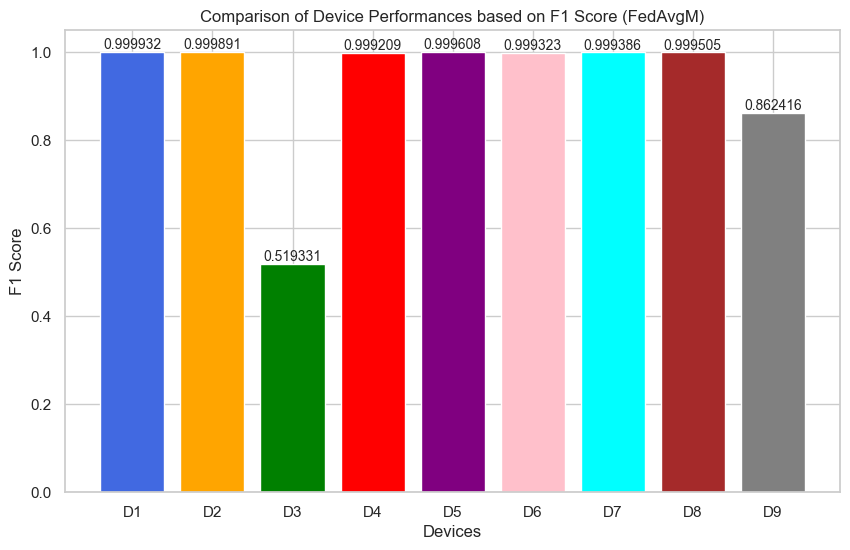

In [30]:
# Create lists to store the performance metrics for each device
devices = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
device_colors = ['royalblue', 'orange', 'green', 'red', 'purple', 'pink', 'cyan', 'brown', 'gray']

f1_scores = []

# Calculate and store the F1 score for each device
for i, tr, mix_data, mix_label in zip(range(1, 10), [tr_1, tr_2, tr_3, tr_4, tr_5, tr_6, tr_7, tr_8, tr_9],
                                      [mix_data_1, mix_data_2, mix_data_3, mix_data_4, mix_data_5, mix_data_6, mix_data_7, mix_data_8, mix_data_9],
                                      [mix_label_1, mix_label_2, mix_label_3, mix_label_4, mix_label_5, mix_label_6, mix_label_7, mix_label_8, mix_label_9]):
    performance = get_mix_result(global_model, tr, mix_data, mix_label)
    f1_scores.append(performance['F1_score'])

# Plotting the F1 scores in a bar plot
plt.figure(figsize=(10, 6))
bars=plt.bar(devices, f1_scores, color=device_colors)
plt.xlabel('Devices')
plt.ylabel('F1 Score')
plt.title('Comparison of Device Performances based on F1 Score (FedAvgM)')

# Adding percentage labels on top of the bars
for bar, value in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.6f}', ha='center', va='bottom', fontsize=10)


plt.show()


In [31]:
print(f1_scores)

[0.9999318744838975, 0.9998906244493245, 0.5193305541129186, 0.9992089078491275, 0.9996078889353565, 0.9993225477888055, 0.9993857199223253, 0.9995053874811612, 0.8624164931073459]


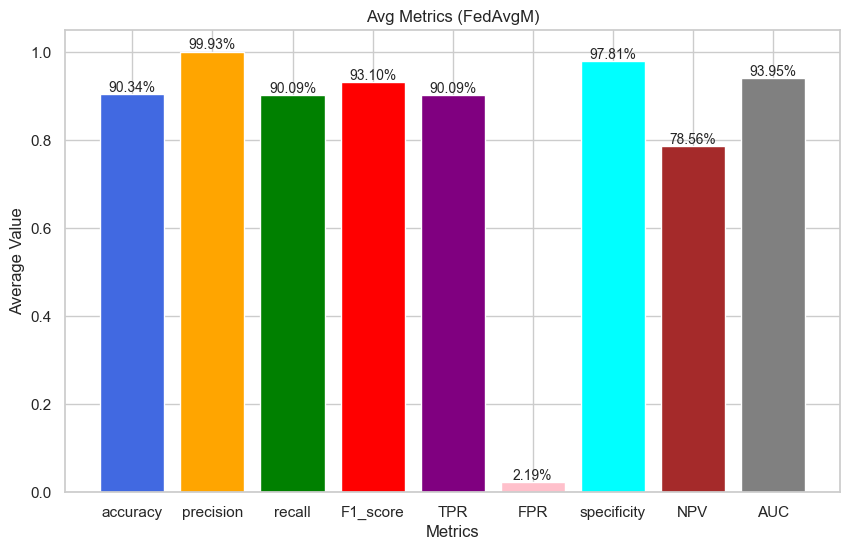

In [32]:
# Create lists to store the performance metrics for each device
devices = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']
device_colors = ['royalblue', 'orange', 'green', 'red', 'purple', 'pink', 'cyan', 'brown', 'gray']

f1_scores = []
AucAvg=0
F1Avg=0
TPRAvg=0
FPRAvg=0
accuracyAvg=0
precisionAvg=0
recallAvg=0
specificityAvg=0
NPVAvg=0
# Calculate and store the F1 score for each device
for i, tr, mix_data, mix_label in zip(range(1, 10), [tr_1, tr_2, tr_3, tr_4, tr_5, tr_6, tr_7, tr_8, tr_9],
                                      [mix_data_1, mix_data_2, mix_data_3, mix_data_4, mix_data_5, mix_data_6, mix_data_7, mix_data_8, mix_data_9],
                                      [mix_label_1, mix_label_2, mix_label_3, mix_label_4, mix_label_5, mix_label_6, mix_label_7, mix_label_8, mix_label_9]):
    performance = get_mix_result(global_model, tr, mix_data, mix_label)
    AucAvg+=performance['AUC']
    F1Avg+=performance['F1_score']
    TPRAvg+=performance['TPR']
    FPRAvg+=performance['FPR']
    accuracyAvg+=performance['accuracy']
    precisionAvg+=performance['precision']
    recallAvg+=performance['recall']
    specificityAvg+=performance['specificity']
    NPVAvg+=performance['NPV']
   

AvgMetrics=[accuracyAvg/9, precisionAvg/9, recallAvg/9, F1Avg/9, TPRAvg/9, FPRAvg/9, specificityAvg/9, NPVAvg/9, AucAvg/9]
metrics = ['accuracy', 'precision', 'recall', 'F1_score', 'TPR', 'FPR', 'specificity', 'NPV', 'AUC']

# Plotting the F1 scores in a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, AvgMetrics, color=device_colors)
plt.xlabel('Metrics')
plt.ylabel('Average Value')
plt.title('Avg Metrics (FedAvgM)')

# Adding percentage labels on top of the bars
for bar, value in zip(bars, AvgMetrics):
    plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2%}', ha='center', va='bottom', fontsize=10)
plt.show()




In [33]:
print(metrics)
print(AvgMetrics)

['accuracy', 'precision', 'recall', 'F1_score', 'TPR', 'FPR', 'specificity', 'NPV', 'AUC']
[0.9033613303279867, 0.9993243918152016, 0.9009040619466595, 0.9309555553478069, 0.9009039999999998, 0.021898, 0.9781019737703931, 0.7856053669961991, 0.9395030178585263]


In [34]:
# Save the trained federated model
torch.save(global_model.state_dict(), 'federated_model.pth')


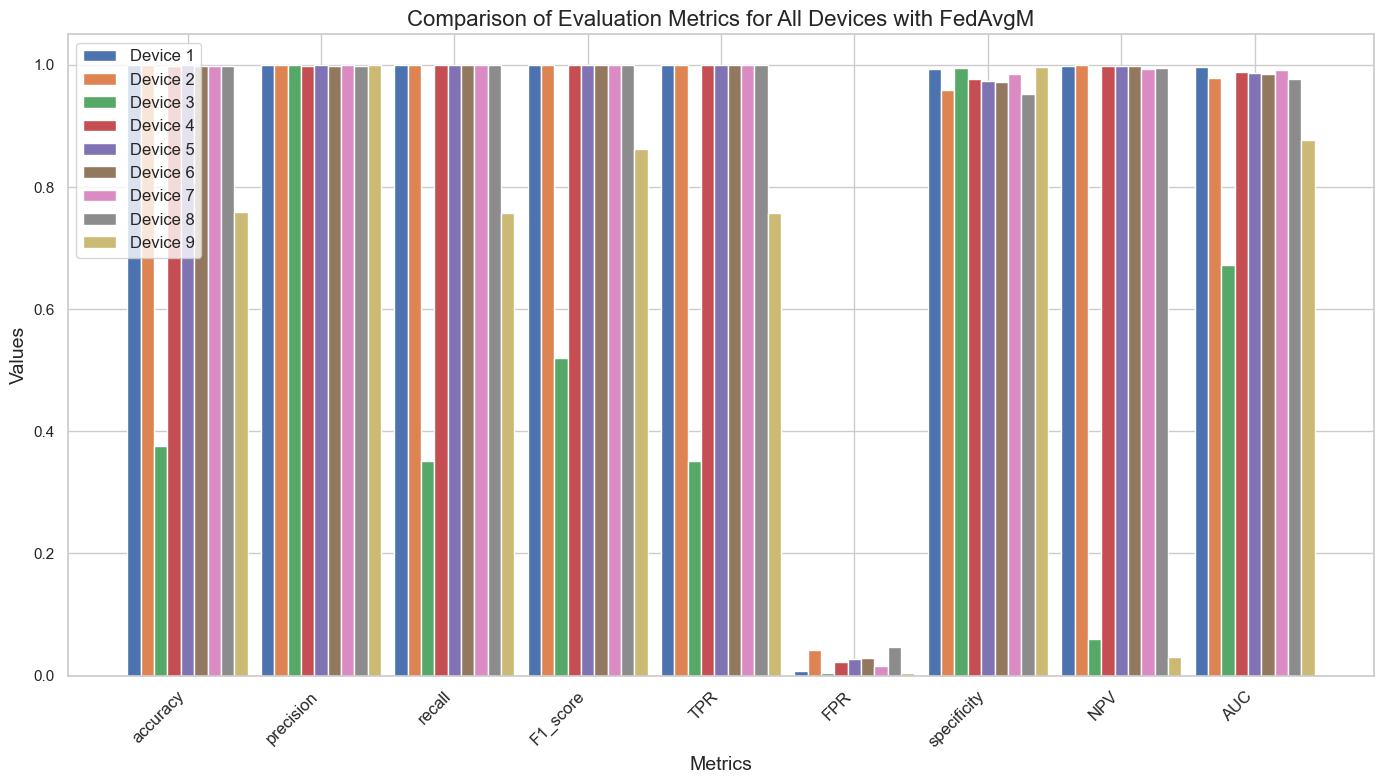

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluation results for all 9 devices
results = {
    'Device 1': get_mix_result(global_model, tr_1, mix_data_1, mix_label_1),
    'Device 2': get_mix_result(global_model, tr_2, mix_data_2, mix_label_2),
    'Device 3': get_mix_result(global_model, tr_3, mix_data_3, mix_label_3),
    'Device 4': get_mix_result(global_model, tr_4, mix_data_4, mix_label_4),
    'Device 5': get_mix_result(global_model, tr_5, mix_data_5, mix_label_5),
    'Device 6': get_mix_result(global_model, tr_6, mix_data_6, mix_label_6),
    'Device 7': get_mix_result(global_model, tr_7, mix_data_7, mix_label_7),
    'Device 8': get_mix_result(global_model, tr_8, mix_data_8, mix_label_8),
    'Device 9': get_mix_result(global_model, tr_9, mix_data_9, mix_label_9),
}

# Evaluation metrics to plot
metrics = ['accuracy', 'precision', 'recall', 'F1_score', 'TPR', 'FPR', 'specificity', 'NPV', 'AUC']

# Create a bar chart with grouped bars for each device
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.1
index = np.arange(len(metrics))

# Create bars for each device and each metric
for i, device in enumerate(results.keys()):
    values = [results[device][metric] for metric in metrics]
    ax.bar(index + i * bar_width, values, bar_width, label=device)

# Set labels, title, and legend
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Values', fontsize=14)
ax.set_title('Comparison of Evaluation Metrics for All Devices with FedAvgM', fontsize=16)
ax.set_xticks(index + (len(results) - 1) * bar_width / 2)
ax.set_xticklabels(metrics, fontsize=12, rotation=45, ha='right')
ax.legend(fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()
